## Imports

In [1]:
import math
import os
import random

import git
import imageio
import magnum as mn
import numpy as np

import cv2

%matplotlib inline
from matplotlib import pyplot as plt

# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
print(f"data_path = {data_path}")
# @markdown Optionally configure the save path for video output:
output_directory = os.path.join(
    dir_path, "examples/tutorials/nav_output/"
)  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

from scripts_utils import *

import quaternion


/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data_path = /home/jack/Desktop/habitat-sim/data


## Settings

In [2]:
show_video = True
do_make_video = True
display = True

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

meters_per_pixel = 0.025

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [3]:
import os

def update_string_with_glb_file(data_folder, str_value):
    file_paths = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.glb'):
                # Extract the file name without extension
                glb_file_name = os.path.splitext(file)[0]
                
                # Replace the string value with the .glb file name
                str_value = glb_file_name
                
                # Full path of the .glb file
                glb_file_path = os.path.join(root, file)
                
                file_paths.append(glb_file_path)
                
                # If you need to save this update somewhere, you can add your saving logic here
                
    return file_paths

# Example usage
data_folder = data_path + '/scene_datasets/hm3d-minival-habitat-v0.2/' # Root data folder containing subfolders with .glb files
initial_str_value = "initial_value"

# Update the string value with the .glb file name
updated_str_value = update_string_with_glb_file(data_folder, initial_str_value)

print(f"Updated string value: {updated_str_value}")

Updated string value: ['/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00807-rsggHU7g7dh/rsggHU7g7dh.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00809-Qpor2mEya8F/Qpor2mEya8F.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00803-k1cupFYWXJ6/k1cupFYWXJ6.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00808-y9hTuugGdiq/y9hTuugGdiq.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00802-wcojb4TFT35/wcojb4TFT35.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00805-SUHsP6z2gcJ/SUHsP6z2gcJ.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00806-tQ5s4ShP627/tQ5s4ShP627.basis.glb', '/home/jack/Deskt

In [4]:
# This is the scene we are going to load.
# we support a variety of mesh formats, such as .glb, .gltf, .obj, .ply
# test_scene = os.path.join(
#     data_path, "scene_datasets/hm3d-minival-habitat-v0.2/00808-y9hTuugGdiq/y9hTuugGdiq.basis.glb"
# )


# pick a random index between 0 and len(updated_str_value)
random_index = random.randint(0, len(updated_str_value)-1)
test_scene = updated_str_value[random_index]


rgb_sensor = True

sim_settings = {
    "scene": test_scene,  # Scene path
    "default_agent": 0,  # Index of the default agent
    "sensor_height": 0.0, #1.5,  # Height of sensors in meters, relative to the agent
    "agent_height": 1.0,  # Height of the agent in meters
    "agent_radius": 0.1,  # Radius of the agent in meters
    "width": 256,  # Spatial resolution of the observations
    "height": 256, 
    "sensor_hfov": 45,  # Horizontal field of view of the sensors
    "color_sensor": rgb_sensor,  # RGB sensor
    "seed": 1,  # used in the random navigation
    "enable_physics": True,  # kinematics only
}

In [5]:
# test_scene_file = '/home/chitianqilin/habitat-source/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb'
 

In [6]:
cfg = make_cfg(sim_settings)
# Needed to handle out of order cell run in Jupyter
try:  # Got to make initialization idiot proof
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[12:15:06:446876]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[12:15:06:447047]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-minival-habitat-v0.2/00806-tQ5s4ShP627/tQ5s4ShP627.basis.scndoes not exist.  Aborting load.
[12:15:06:447063]:[Warning]:[Scene] SemanticScene.cpp(

Renderer: Quadro P1000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 555.42.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


## Initialize Agent

In [7]:
# initialize an agent
agent = sim.initialize_agent(sim_settings["default_agent"])

# Set agent state
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([1, 1, 0.0])  # in world space
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

sensor_spec = sim._sensors.get("color_sensor")
print("sensor_spec: ", sensor_spec._spec.__dict__)



agent_state: position [1. 1. 0.] rotation quaternion(1, 0, 0, 0)
sensor_spec:  {'__noise_model_kwargs': {}}


In [8]:
# Print semantic annotation information (id, category, bounding box details)
# about levels, regions and objects in a hierarchical fashion
scene = sim.semantic_scene
print_scene_recur(scene)

House has 0 levels, 0 regions and 0 objects
House center:[0. 0. 0.] dims:[-inf -inf -inf]


## Compute NavMesh

Successfully snapped point to: [-0.8601506   0.10557699 -0.04527134]
Agent state: AgentState(position=array([-0.8601506 ,  0.10557699, -0.04527134], dtype=float32), rotation=quaternion(0.7109135389328, -0, -0.703279376029968, -0), sensor_states={'color_sensor': SixDOFPose(position=array([-0.8601506 ,  0.10557699, -0.04527134], dtype=float32), rotation=quaternion(0.7109135389328, 0, -0.703279376029968, 0))})
 position = [-0.8601506   0.10557699 -0.04527134]
 rotation = quaternion(0.7109135389328, -0, -0.703279376029968, -0)
 orientation (about Y) = 1.56
rgb {'color_sensor': array([[[189, 165, 140, 255],
        [189, 165, 140, 255],
        [189, 165, 140, 255],
        ...,
        [184, 158, 134, 255],
        [184, 158, 134, 255],
        [184, 158, 134, 255]],

       [[189, 165, 140, 255],
        [189, 165, 140, 255],
        [189, 165, 140, 255],
        ...,
        [184, 158, 134, 255],
        [184, 158, 134, 255],
        [184, 158, 134, 255]],

       [[189, 165, 140, 255],


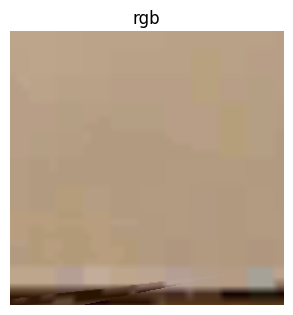


Display topdown map with agent:


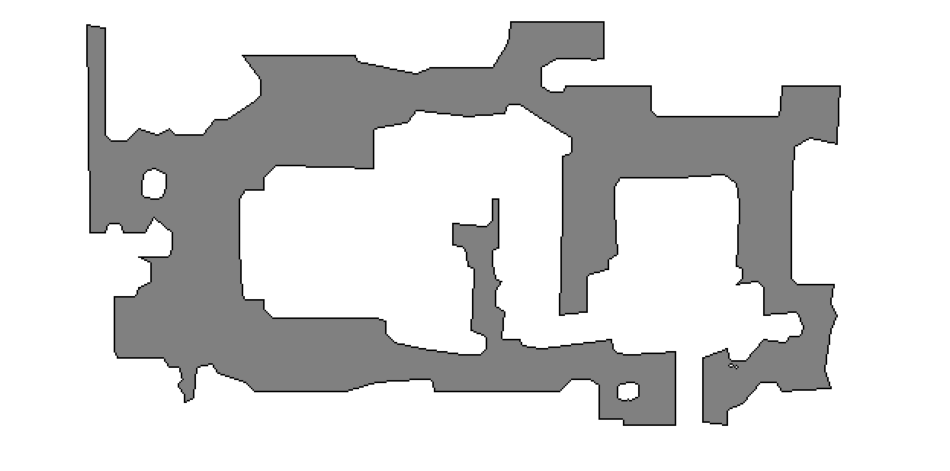

{'color_sensor': array([[[144, 126, 119, 255],
         [143, 125, 118, 255],
         [143, 125, 118, 255],
         ...,
         [173, 165, 148, 255],
         [173, 165, 148, 255],
         [173, 165, 148, 255]],
 
        [[143, 125, 118, 255],
         [143, 125, 118, 255],
         [143, 125, 118, 255],
         ...,
         [173, 165, 148, 255],
         [173, 165, 148, 255],
         [173, 165, 148, 255]],
 
        [[146, 128, 121, 255],
         [144, 126, 119, 255],
         [143, 125, 118, 255],
         ...,
         [173, 165, 148, 255],
         [173, 165, 148, 255],
         [173, 165, 148, 255]],
 
        ...,
 
        [[153, 135, 129, 255],
         [155, 137, 130, 255],
         [156, 138, 132, 255],
         ...,
         [231, 207, 173, 255],
         [231, 207, 173, 255],
         [231, 207, 173, 255]],
 
        [[154, 136, 129, 255],
         [155, 137, 131, 255],
         [156, 138, 132, 255],
         ...,
         [231, 207, 173, 255],
         [231, 207,

In [9]:
## Recompute NavMesh:

# Take a moment to edit some parameters and visualize the resulting NavMesh. Consider agent_radius and agent_height as the most impactful starting point. Note that large variations from the defaults for these parameters (e.g. in the case of very small agents) may be better supported by additional changes to cell_size and cell_height.
navmesh_settings = habitat_sim.NavMeshSettings()

# Choose Habitat-sim defaults (e.g. for point-nav tasks), or custom settings.
use_custom_settings = True  # @param {type:"boolean"}
sim.navmesh_visualization = True  # @param {type:"boolean"}
navmesh_settings.set_defaults()
if use_custom_settings:
    #@markdown Configure the following NavMeshSettings for customized NavMesh recomputation.
    #@markdown **Voxelization parameters**:
    navmesh_settings.cell_size = 0.05 #default = 0.05
    navmesh_settings.cell_height = 0.2 #default = 0.2

    #@markdown **Agent parameters**:
    navmesh_settings.agent_height = sim_settings["agent_height"] #default = 1.5
    navmesh_settings.agent_radius = sim_settings["agent_radius"] #default = 0.1
    navmesh_settings.agent_max_climb = 0.2 #default = 0.2
    navmesh_settings.agent_max_slope = 45 # default = 45.0
    
    # @markdown **Navigable area filtering options**:
    navmesh_settings.filter_low_hanging_obstacles = True  # default = True
    navmesh_settings.filter_ledge_spans = True # default = True
    navmesh_settings.filter_walkable_low_height_spans = True  # default = True

    #@markdown **Detail mesh generation parameters**:
    #@markdown For more details on the effects
    navmesh_settings.region_min_size = 20 #default = 20
    navmesh_settings.region_merge_size = 20 #default = 20
    navmesh_settings.edge_max_len = 12.0 #default = 12.0
    navmesh_settings.edge_max_error = 1.3 #default = 1.3
    navmesh_settings.verts_per_poly = 6.0 #default = 6.0
    navmesh_settings.detail_sample_dist = 6.0 #default = 6.0
    navmesh_settings.detail_sample_max_error = 1.0 # default = 1.0

    # @markdown **Include STATIC Objects**:
    # @markdown Optionally include all instanced RigidObjects with STATIC MotionType as NavMesh constraints.
    navmesh_settings.include_static_objects = True  # @param {type:"boolean"}
    # default = False

navmesh_success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)

if not navmesh_success:
    print("Failed to build the navmesh! Try different parameters?")
else:
    # @markdown **Agent parameters**:
    agent_state = sim.agents[0].get_state()
    set_random_valid_state = False  
    seed = 5  
    sim.seed(seed)
    orientation = 0
    if set_random_valid_state:
        agent_state.position = sim.pathfinder.get_random_navigable_point()
        orientation = random.random() * math.pi * 2.0
    # Optionally configure the agent state (overrides random state):
    set_agent_state = True  # @param {type:"boolean"}
    try_to_make_valid = True  # @param {type:"boolean"}
    if set_agent_state:
        pos_x = 0  # @param {type:"number"}
        pos_y = 0  # @param {type:"number"}
        pos_z = 0.0  # @param {type:"number"}
        # Y axis rotation (radians):
        orientation = 1.56  # @param {type:"number"}
        agent_state.position = np.array([pos_x, pos_y, pos_z])
        if try_to_make_valid:
            snapped_point = np.array(sim.pathfinder.snap_point(agent_state.position))
            if not np.isnan(np.sum(snapped_point)):
                print("Successfully snapped point to: " + str(snapped_point))
                agent_state.position = snapped_point
    if set_agent_state or set_random_valid_state:
        agent_state.rotation = utils.quat_from_magnum(
            mn.Quaternion.rotation(-mn.Rad(orientation), mn.Vector3(0, 1.0, 0))
        )
        sim.agents[0].set_state(agent_state)

    agent_state = sim.agents[0].get_state()
    print("Agent state: " + str(agent_state))
    print(" position = " + str(agent_state.position))
    print(" rotation = " + str(agent_state.rotation))
    print(" orientation (about Y) = " + str(orientation))

    observations = sim.get_sensor_observations()
    rgb = observations["color_sensor"]
    print("rgb", observations)

    if display:
        display_sample(rgb)
        # **Map parameters**:
        agent_pos = agent_state.position
        # topdown map at agent position
        top_down_map = maps.get_topdown_map(
            sim.pathfinder, height=agent_pos[1], meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        top_down_map = recolor_map[top_down_map]
        grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
        # convert world agent position to maps module grid point
        agent_grid_pos = maps.to_grid(
            agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder
        )
        agent_forward = utils.quat_to_magnum(
            sim.agents[0].get_state().rotation
        ).transform_vector(mn.Vector3(0, 0, -1.0))
        agent_orientation = math.atan2(agent_forward[0], agent_forward[2])
        # draw the agent and trajectory on the map
        # maps.draw_agent(
        #     top_down_map, agent_grid_pos, agent_orientation, agent_radius_px=4
        # )
        print("\nDisplay topdown map with agent:")
        display_map(top_down_map)

sim.reset()

In [10]:
print(top_down_map.shape)
print(type(top_down_map))

(296, 610, 3)
<class 'numpy.ndarray'>


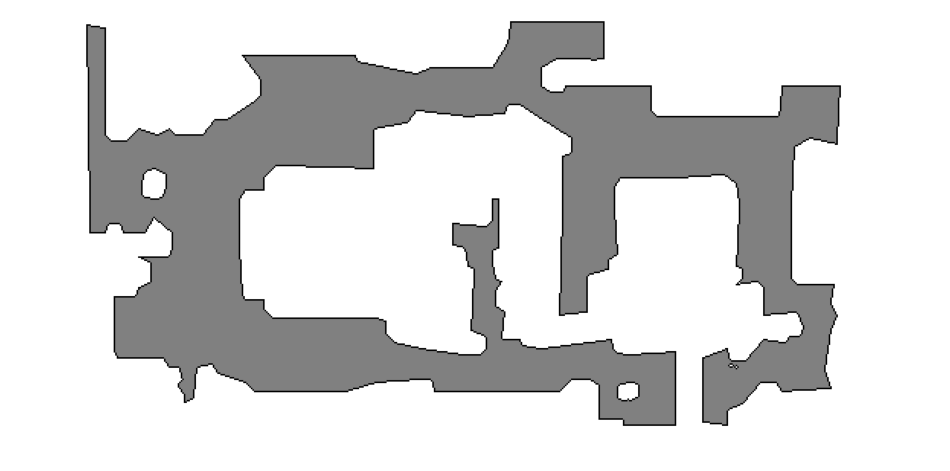

In [11]:
from scipy.ndimage import label, find_objects

# Convert to binary map where 1 is navigable and 0 is not
binary_map = (top_down_map == 128).astype(np.uint8)

# Label connected components
labeled_map, num_features = label(binary_map)

# Find the largest connected component
sizes = np.bincount(labeled_map.ravel())
sizes[0] = 0  # Background size to 0
largest_component_label = sizes.argmax()

# Create a mask for the largest component
largest_component_mask = (labeled_map == largest_component_label)

# Create the final navigation map, keeping the borders as they are
final_navigation_map = np.where(largest_component_mask, 128, 255)

# Ensure the borders of the largest component are kept as they are in the original map
final_navigation_map[top_down_map == 0] = 0

# Display the final navigation map
display_map(final_navigation_map)

In [12]:
top_down_map = (final_navigation_map).astype(np.uint8)

In [13]:
print(top_down_map.shape)
print(type(top_down_map))

(296, 610, 3)
<class 'numpy.ndarray'>


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from PIL import Image
from scipy.sparse.csgraph import connected_components
from scipy.spatial import KDTree

def edge_crosses_border(p1, p2, img_array):
    """
    Check if the edge between points p1 and p2 crosses a border in the image.
    
    Parameters:
    p1, p2 (tuple): Points representing the edge.
    img_array (np.array): Image array representing the topdown map.
    
    Returns:
    bool: True if the edge crosses a border, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x_values = np.linspace(x1, x2, 1000, dtype=int)
    y_values = np.linspace(y1, y2, 1000, dtype=int)
    
    for x, y in zip(x_values, y_values):
        if np.all(img_array[y, x] == [255, 255, 255]):
            return True
    return False

## Generating Numerous Random Points, Capturing and Pre-Processing Images

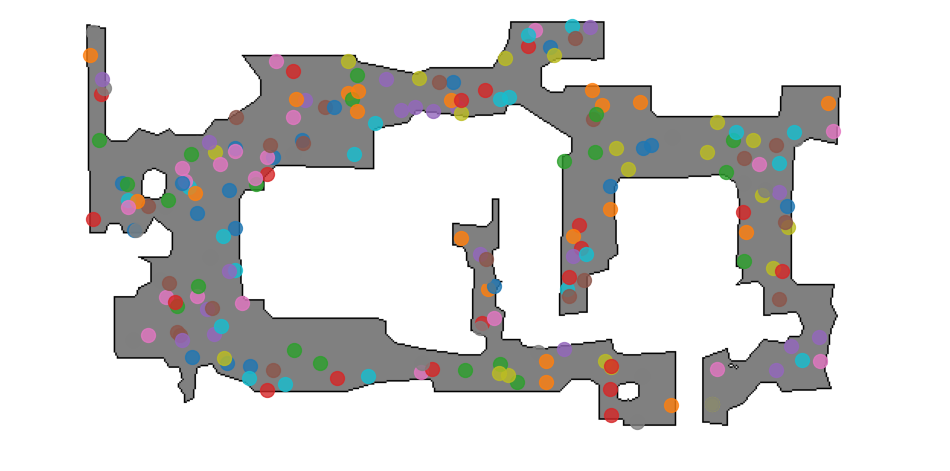

In [15]:

import numpy as np
import matplotlib.pyplot as plt
import habitat_sim
import magnum as mn

points_manager = PointsManager()
random_points = []
num_queries = 250 # number of random images 

while len(random_points) < num_queries:
    points_manager.generate_random_point(top_down_map.shape[0], top_down_map.shape[1])
    if top_down_map[points_manager.random_point[0], points_manager.random_point[1]][0] == 128:
        random_point = [points_manager.random_point[1], points_manager.random_point[0]] 
        random_points.append(random_point) 

display_map(top_down_map, key_points=random_points)

def degrees_to_magnum_rad(deg):
    return mn.Rad(deg * np.pi / 180.0)

random_panoramas = []

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    seed = 4  
    sim.pathfinder.seed(seed)

    scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb

    display_path_agent_renders = True
    if display_path_agent_renders:
        agent_state = habitat_sim.AgentState()
        random_panoramas = [] 

        for point in random_points:
            vis_frames = [] 

            point_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
            point_3d = mn.Vector3(point_3d)
            agent_state.position = point_3d 

            target_orientation_matrix = mn.Matrix4.look_at(
                point_3d, point_3d + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
            )
            initial_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())

            for rotation in [0, 45, 90, 135, 180, 225, 270, 315]:
                rad = degrees_to_magnum_rad(rotation) 
                rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))
                total_orientation_q = rotation_q * initial_orientation_q 

                q = total_orientation_q
                agent_state.rotation = utils.quat_from_magnum(total_orientation_q)

                agent.set_state(agent_state)

                observations = sim.get_sensor_observations()
                rgb = observations["color_sensor"]
                vis_frames.append(rgb)

            images = vis_frames[::-1]
            random_panorama = stitch_images(images)[:, :, :3]

            # plt.imshow(random_panorama)
            # plt.axis("off")
            # plt.show()

            random_panoramas.append(random_panorama)

random_panoramas = [im[:, :, :3] for im in random_panoramas]


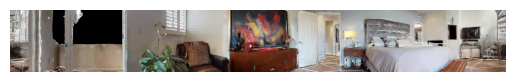

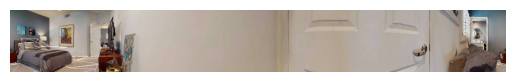

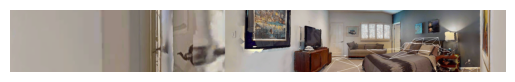

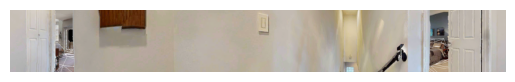

In [16]:
for i in range (0,4):
    plt.imshow(random_panoramas[i])
    plt.axis("off")
    plt.show()

In [17]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

def image_to_feature_vector(image, kmeans_model):
    
    _, descriptors = extract_sift_features(image)
    
    if descriptors is not None:
        # Predict the nearest cluster each SIFT descriptor belongs to
        predicted_labels = kmeans_model.predict(descriptors)
        
        # Create histogram of features
        feature_vector = np.bincount(predicted_labels, minlength=kmeans_model.n_clusters)
        
        # Normalize the histogram to form the final feature vector
        feature_vector = feature_vector / np.linalg.norm(feature_vector)
        
        return feature_vector
    else:
        # Return a zero vector if no descriptors are found
        return np.zeros(kmeans_model.n_clusters)

pre_processing = "mobilenet_v3"  # @param ["mobilenet_v3", "SIFT"]

random_panoramas_flat = []

if pre_processing == "mobilenet_v3":
    for panorama in random_panoramas:
        image = Image.fromarray(panorama)
        # Step 3: Preprocess the image
        input_tensor = preprocess_image(image)

        # Step 4: Load pre-trained MobileNetV3 model
        model = models.mobilenet_v3_large(pretrained=True)
        model.eval()

        # Step 5: Extract features
        with torch.no_grad():
            features = model.features(input_tensor)

        # Step 6: Convert the feature maps to a numpy array and visualize
        features_np = features.squeeze().cpu().numpy()
        num_feature_maps = features_np.shape[0]

        # Step 8: Apply global average pooling
        global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        pooled_features = global_avg_pool(features).squeeze().cpu().numpy()

        random_panoramas_flat.append(pooled_features)

elif pre_processing == "SIFT":
    feature_vectors = []
    for panorama in random_panoramas:
        random_panorama_flat = image_to_feature_vector(panorama, kmeans_model)
        feature_vectors.append(random_panorama_flat)
    
    # Convert the list of feature vectors to a numpy array
    random_panorama_features = np.array(feature_vectors)


/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
import numpy as np
from collections import defaultdict

# Load the data
all_panoramas = np.load("all_panoramas.npy")
all_envs = np.load("all_envs.npy")
all_coords = np.load("all_coords.npy")

# Utility functions
def extract_relevant_path(full_path):
    start_index = full_path.find("00")
    return full_path[start_index:] if start_index != -1 else None

def are_paths_equivalent(path1, path2):
    relevant_path1 = extract_relevant_path(path1)
    relevant_path2 = extract_relevant_path(path2)
    return relevant_path1 == relevant_path2

# Create a dictionary to hold environment-specific data
env_to_indices = defaultdict(list)

# Populate the dictionary with indices for each environment
for idx, env_path in enumerate(all_envs):
    relevant_path = extract_relevant_path(env_path)
    if relevant_path:
        env_to_indices[relevant_path].append(idx)

# Now, split the panoramas and coordinates based on environments
env_specific_panoramas = {}
env_specific_coords = {}

for env_path, indices in env_to_indices.items():
    env_specific_panoramas[env_path] = all_panoramas[indices]
    env_specific_coords[env_path] = all_coords[indices]

In [20]:
def find_closest_coordinates(coords_in_test_env, target_coord, num_closest=4):
    target_coord = np.array(target_coord)
    distances = np.linalg.norm(coords_in_test_env - target_coord, axis=1)
    closest_indices = np.argsort(distances)[:num_closest]
    closest_coords = coords_in_test_env[closest_indices]

    return closest_coords

def find_closest_unobstructed_coordinates(query_coord, coords_in_test_env):
    closest_coords = find_closest_coordinates(coords_in_test_env, query_coord, 4)

    for coord in closest_coords:
        if not edge_crosses_border(query_coord, coord,  top_down_map):
           return coord




In [21]:
print(env_specific_panoramas.keys())

dict_keys(['00808-y9hTuugGdiq/y9hTuugGdiq.basis.glb', '00801-HaxA7YrQdEC/HaxA7YrQdEC.basis.glb', '00809-Qpor2mEya8F/Qpor2mEya8F.basis.glb', '00803-k1cupFYWXJ6/k1cupFYWXJ6.basis.glb', '00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb', '00805-SUHsP6z2gcJ/SUHsP6z2gcJ.basis.glb', '00807-rsggHU7g7dh/rsggHU7g7dh.basis.glb', '00800-TEEsavR23oF/TEEsavR23oF.basis.glb', '00802-wcojb4TFT35/wcojb4TFT35.basis.glb', '00806-tQ5s4ShP627/tQ5s4ShP627.basis.glb'])


Test Env = 00806-tQ5s4ShP627/tQ5s4ShP627.basis.glb
Envs to Process = ['00806-tQ5s4ShP627/tQ5s4ShP627.basis.glb', '00808-y9hTuugGdiq/y9hTuugGdiq.basis.glb', '00801-HaxA7YrQdEC/HaxA7YrQdEC.basis.glb', '00809-Qpor2mEya8F/Qpor2mEya8F.basis.glb', '00803-k1cupFYWXJ6/k1cupFYWXJ6.basis.glb', '00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb', '00805-SUHsP6z2gcJ/SUHsP6z2gcJ.basis.glb', '00807-rsggHU7g7dh/rsggHU7g7dh.basis.glb', '00800-TEEsavR23oF/TEEsavR23oF.basis.glb', '00802-wcojb4TFT35/wcojb4TFT35.basis.glb']


Number of environments: 1
Number of points: 13
k1 score = 0.6627218934911243
k4 score = 0.8994082840236687
Number of sampling errors = 31

Number of environments: 2
Number of points: 45
k1 score = 0.6094674556213018
k4 score = 0.7810650887573964
Number of sampling errors = 31

Number of environments: 3
Number of points: 73
k1 score = 0.5976331360946746
k4 score = 0.7514792899408284
Number of sampling errors = 31

Number of environments: 4
Number of points: 112
k1 score = 0.5798816568047337
k4 score = 0.727810650887574
Number of sampling errors = 31

Number of environments: 5
Number of points: 120
k1 score = 0.5798816568047337
k4 score = 0.727810650887574
Number of sampling errors = 31

Number of environments: 6
Number of points: 170
k1 score = 0.5680473372781065
k4 score = 0.6982248520710059
Number of sampling errors = 31

Number of environments: 7
Number of points: 229
k1 score = 0.5562130177514792
k4 score = 0.6804733727810651
Number of sampling errors = 31

Number of environments: 8

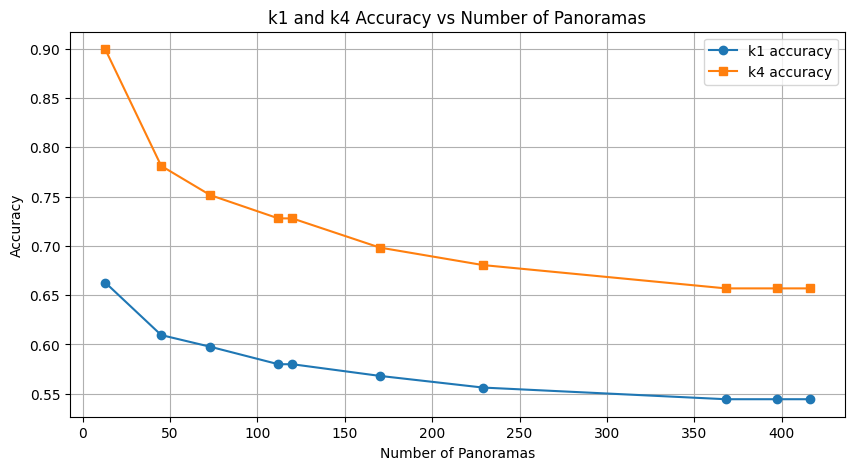

In [22]:
import numpy as np
import hnswlib
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming test_env is defined
# Assuming env_specific_panoramas and env_specific_coords are dictionaries created earlier

test_env = extract_relevant_path(test_scene)

# Initialize empty subsets and results containers
subset_panoramas = []
subset_coords = []
subset_envs = []
k1_scores = []
k4_scores = []
num_points = []

# Start with the test environment
envs_to_process = list(env_specific_panoramas.keys())
first_env_to_process = envs_to_process.pop(envs_to_process.index(test_env))  # Ensure test_env is processed first
envs_to_process.insert(0, first_env_to_process)

print(f"Test Env = {test_env}")
print(f"Envs to Process = {envs_to_process}")

# Iterate through the environments
for current_env in envs_to_process:
    # Add the current environment's data to the subset
    subset_panoramas.extend(env_specific_panoramas[current_env])
    subset_coords.extend(env_specific_coords[current_env])

    # Convert lists to numpy arrays
    subset_panoramas_np = np.array(subset_panoramas)
    subset_coords_np = np.array(subset_coords)

    # Set up the HNSW index
    dim = subset_panoramas_np.shape[1]  # Dimension of the feature vectors
    num_elements = subset_panoramas_np.shape[0]  # Number of panoramas
    k = 4  # Number of neighbors to search for

    # Create new subset of envs corresponding to indexes to check correct env
    subset_envs.extend([current_env] * num_elements)

    p = hnswlib.Index(space='cosine', dim=dim)
    p.init_index(max_elements=num_elements, ef_construction=200, M=16)
    p.add_items(subset_panoramas_np)
    p.set_ef(50)

    # Perform ANN search
    result_indices = []
    result_distances = []
    for idx, random_panorama_flat in enumerate(random_panoramas_flat):
        indices, distances = p.knn_query(random_panorama_flat, k=k)
        result_indices.append(indices)
        result_distances.append(distances)

    # Calculate k1 and k4 scores
    sampling_errors = 0

    k1_score = 0
    k4_score = 0

    for i, random_point in enumerate(random_points):
        point = np.array(random_points[i])
        closest_coord = find_closest_unobstructed_coordinates(point, env_specific_coords[test_env])

        if closest_coord is None:
            sampling_errors += 1
            continue

        first_coord = subset_coords_np[result_indices[i][0][0]]
        first_env = subset_envs[result_indices[i][0][0]] 

        if np.array_equal(first_coord, closest_coord) and are_paths_equivalent(first_env, test_env):
            k1_score += 1
            k4_score += 1
        else:
            for j in range(4):
                current_k_coord = subset_coords_np[result_indices[i][0][j]]
                current_k_env = subset_envs[result_indices[i][0][j]]
                if np.array_equal(current_k_coord, closest_coord) and are_paths_equivalent(current_k_env, test_env):
                    k4_score += 1
                    break

    k1_score = k1_score / (len(random_points) - sampling_errors)
    k4_score = k4_score / (len(random_points) - sampling_errors)

    # Store the results
    k1_scores.append(k1_score)
    k4_scores.append(k4_score)
    num_points.append(len(subset_panoramas_np))

    print(f"Number of environments: {envs_to_process.index(current_env) + 1}")
    print(f"Number of points: {len(subset_panoramas_np)}")
    print(f"k1 score = {k1_score}")
    print(f"k4 score = {k4_score}")
    print(f"Number of sampling errors = {sampling_errors}\n")

print(f"Overall sampling error = {sampling_errors/len(random_points)}")

plt.figure(figsize=(10, 5))
plt.plot(num_points, k1_scores, label='k1 accuracy', marker='o')  # Adding markers for k1 accuracy
plt.plot(num_points, k4_scores, label='k4 accuracy', marker='s')  # Adding markers for k4 accuracy
plt.xlabel('Number of Panoramas')
plt.ylabel('Accuracy')
plt.title('k1 and k4 Accuracy vs Number of Panoramas')
plt.legend()
plt.grid(True)
plt.show()